# Fun with glow

Glow is a normalizing flow, which can be used to create realisitic looking faces. Here we use a pretrained network.  


**Usage:** Exceute the code and follow finish the excercises. At the end the possibility to use your own photos is given 

**Dataset:** The dataset is the celeba-Hq dataset with of pictures from celebrities.

**Content:** 
* Downloading of weights 
* Importing the weights and a few help functions (just execute the code)
* Fitting the flow to the 2-dimensional data 
* Sampling faces 
* Moving in the latent space: Morphing between two images
**Text fett markieren**

**Notes:**
The code has be taken in great part from: https://github.com/openai/glow/. 

It's highly recomended to use the colab version. Since the weights are storred in TensorFlow 1, we use a TF 1 version.


# Preprocessing

In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 1.x
except:
    IN_COLAB = False

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
import datetime
if (not tf.__version__.startswith('1')): #Checking if tf 1.0 is installed
    print('Please install tensorflow 1.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB, ' date excecuted ', datetime.datetime.now())
if (not IN_COLAB):
  print("It's recommded to run this notebook in colab. Approx 1GB data are downloaded!")

Tensorflow version:  1.15.2  running in colab?:  True  date excecuted  2021-04-12 18:49:24.110717


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.style.use('default')
np.random.seed(42)

### Downloading of the weights

The weights are provided by openai and downloaded.

In [4]:
# If blocksparse doesn't install, use unoptimized model (and set optimized=False in model.py)
#!curl https://storage.googleapis.com/glow-demo/large3/graph_unoptimized.pb > graph_unoptimized.pb
!curl https://openaipublic.azureedge.net/glow-demo/large3/graph_unoptimized.pb > graph_unoptimized.pb
# Get manipulation vectors
!curl https://storage.googleapis.com/glow-demo/z_manipulate.npy > z_manipulate.npy
tf.io.gfile.mkdir('test')
!curl https://raw.githubusercontent.com/openai/glow/master/demo/test/img.png  > test/img.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  854M  100  854M    0     0  31.3M      0  0:00:27  0:00:27 --:--:-- 33.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   133  100   133    0     0   1316      0 --:--:-- --:--:-- --:--:--  1303
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 96427  100 96427    0     0  1177k      0 --:--:-- --:--:-- --:--:-- 1191k


## Loading of the model

Here, we use the code provided by openAI.

In [5]:
#@title Functions provided by openAI { run: "auto" }
graph_path = 'graph_unoptimized.pb'


import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
from PIL import Image
from threading import Lock

lock = Lock()


def get(name):
    return tf.get_default_graph().get_tensor_by_name('import/' + name + ':0')


def tensorflow_session():
    # Init session and params
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # Pin GPU to local rank (one GPU per process)
    config.gpu_options.visible_device_list = str(0)
    sess = tf.Session(config=config)
    return sess


optimized = False
if optimized:
    # Optimized model. Twice as fast as
    # 1. we freeze conditional network (label is always 0)
    # 2. we use fused kernels
    import blocksparse
    graph_path = 'graph_optimized.pb'
    inputs = {
        'dec_eps_0': 'dec_eps_0',
        'dec_eps_1': 'dec_eps_1',
        'dec_eps_2': 'dec_eps_2',
        'dec_eps_3': 'dec_eps_3',
        'dec_eps_4': 'dec_eps_4',
        'dec_eps_5': 'dec_eps_5',
        'enc_x': 'input/enc_x',
    }
    outputs = {
        'dec_x': 'model_3/Cast_1',
        'enc_eps_0': 'model_2/pool0/truediv_1',
        'enc_eps_1': 'model_2/pool1/truediv_1',
        'enc_eps_2': 'model_2/pool2/truediv_1',
        'enc_eps_3': 'model_2/pool3/truediv_1',
        'enc_eps_4': 'model_2/pool4/truediv_1',
        'enc_eps_5': 'model_2/truediv_4'
    }

    def update_feed(feed_dict, bs):
        return feed_dict
else:
    graph_path = 'graph_unoptimized.pb'
    inputs = {
        'dec_eps_0': 'Placeholder',
        'dec_eps_1': 'Placeholder_1',
        'dec_eps_2': 'Placeholder_2',
        'dec_eps_3': 'Placeholder_3',
        'dec_eps_4': 'Placeholder_4',
        'dec_eps_5': 'Placeholder_5',
        'enc_x': 'input/image',
        'enc_x_d': 'input/downsampled_image',
        'enc_y': 'input/label'
    }
    outputs = {
        'dec_x': 'model_1/Cast_1',
        'enc_eps_0': 'model/pool0/truediv_1',
        'enc_eps_1': 'model/pool1/truediv_1',
        'enc_eps_2': 'model/pool2/truediv_1',
        'enc_eps_3': 'model/pool3/truediv_1',
        'enc_eps_4': 'model/pool4/truediv_1',
        'enc_eps_5': 'model/truediv_4'
    }

    def update_feed(feed_dict, bs):
        x_d = 128 * np.ones([bs, 128, 128, 3], dtype=np.uint8)
        y = np.zeros([bs], dtype=np.int32)
        feed_dict[enc_x_d] = x_d
        feed_dict[enc_y] = y
        return feed_dict

with tf.gfile.GFile(graph_path, 'rb') as f:
    graph_def_optimized = tf.GraphDef()
    graph_def_optimized.ParseFromString(f.read())

sess = tensorflow_session()
tf.import_graph_def(graph_def_optimized)

print("Loaded model")

n_eps = 6

# Encoder
enc_x = get(inputs['enc_x'])
enc_eps = [get(outputs['enc_eps_' + str(i)]) for i in range(n_eps)]
if not optimized:
    enc_x_d = get(inputs['enc_x_d'])
    enc_y = get(inputs['enc_y'])

# Decoder
dec_x = get(outputs['dec_x'])
dec_eps = [get(inputs['dec_eps_' + str(i)]) for i in range(n_eps)]

eps_shapes = [(128, 128, 6), (64, 64, 12), (32, 32, 24),
              (16, 16, 48), (8, 8, 96), (4, 4, 384)]
eps_sizes = [np.prod(e) for e in eps_shapes]
eps_size = 256 * 256 * 3


def run(sess, fetches, feed_dict):
    with lock:
        # Locked tensorflow so average server response time to user is lower
        result = sess.run(fetches, feed_dict)
    return result


def flatten_eps(eps):
    # [BS, eps_size]
    return np.concatenate([np.reshape(e, (e.shape[0], -1)) for e in eps], axis=-1)


def unflatten_eps(feps):
    index = 0
    eps = []
    bs = feps.shape[0]  # feps.size // eps_size
    for shape in eps_shapes:
        eps.append(np.reshape(
            feps[:, index: index+np.prod(shape)], (bs, *shape)))
        index += np.prod(shape)
    return eps


def encode(img):
    if len(img.shape) == 3:
        img = np.expand_dims(img, 0)
    bs = img.shape[0]
    assert img.shape[1:] == (256, 256, 3)
    feed_dict = {enc_x: img}

    update_feed(feed_dict, bs)  # For unoptimized model
    return flatten_eps(run(sess, enc_eps, feed_dict))


def decode(feps):
    if len(feps.shape) == 1:
        feps = np.expand_dims(feps, 0)
    bs = feps.shape[0]
    # assert len(eps) == n_eps
    # for i in range(n_eps):
    #     shape = (BATCH_SIZE, 128 // (2 ** i), 128 // (2 ** i), 6 * (2 ** i) * (2 ** (i == (n_eps - 1))))
    #     assert eps[i].shape == shape
    eps = unflatten_eps(feps)

    feed_dict = {}
    for i in range(n_eps):
        feed_dict[dec_eps[i]] = eps[i]

    update_feed(feed_dict, bs)  # For unoptimized model
    return run(sess, dec_x, feed_dict)

 

num_pars = 0
for i,e in enumerate(eps_shapes):
  num_pars += e[0]*e[1]*e[2]
  print('layer z_{} tensor shape'.format(i+1),e)

print('Total number of random variables: ', num_pars)

Loaded model
layer z_1 tensor shape (128, 128, 6)
layer z_2 tensor shape (64, 64, 12)
layer z_3 tensor shape (32, 32, 24)
layer z_4 tensor shape (16, 16, 48)
layer z_5 tensor shape (8, 8, 96)
layer z_6 tensor shape (4, 4, 384)
Total number of random variables:  196608


# Fun with deep learning

## Random samples

We create a random sample from $256 \cdot 256 \cdot 3$ independent Gaussians. We do not sample from $N(0,1)$ but from $N(0,0.7)$, which has been empirically found to create nicer samples. 

This is going from Z $\rightarrow$ Image. Here we use a random Z $\sim N(0,1)$ 

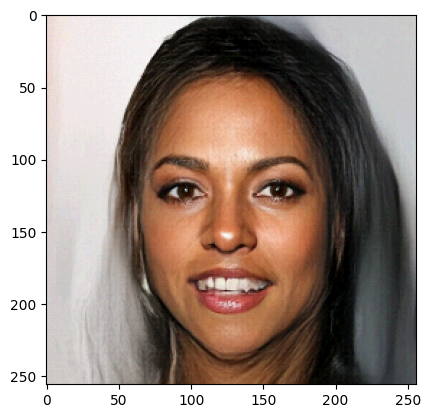

In [6]:
def random(bs=1, eps_std=0.7):
    feps = np.random.normal(scale=eps_std, size=[bs, eps_size]) #eps_size = 256*256*3
    return decode(feps), feps

img = random(eps_std=0.7)[0][0]
plt.imshow(img)

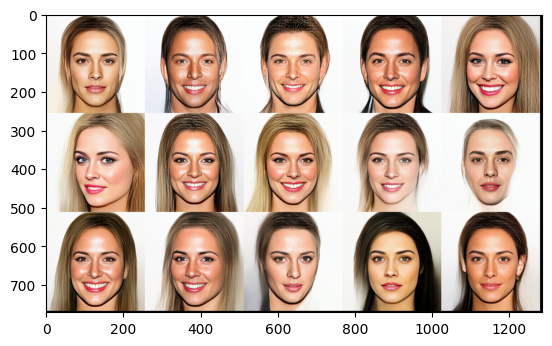

In [7]:
# Creation of figure with 15 random samples
can = np.zeros((3*257,5*257,3),dtype='uint8')
for i in range(3):
  for j in range(5):
    img = random(eps_std=0.5)[0][0]
    s = i*256
    sx = j*256
    can[s:(s+256) , sx:(sx+256),0:3] = img

plt.imshow(can)

# from google.colab import drive
# drive.mount('/content/drive')
# plt.imsave('/content/drive/My Drive/some_random_imges.png',can)

## Going from images to latent vectors 

Now we have a look at the reversed transformation, where we go from images to the latent space. 

Image $\rightarrow$ Z



In [8]:
!curl https://raw.githubusercontent.com/openai/glow/master/demo/web/media/beyonce.png > test/beyonce.jpg
!curl https://raw.githubusercontent.com/openai/glow/master/demo/web/media/leo.png > test/leo.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  123k  100  123k    0     0  1129k      0 --:--:-- --:--:-- --:--:-- 1118k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   97k  100   97k    0     0  1075k      0 --:--:-- --:--:-- --:--:-- 1075k


Text(0.5, 1.0, 'Image')

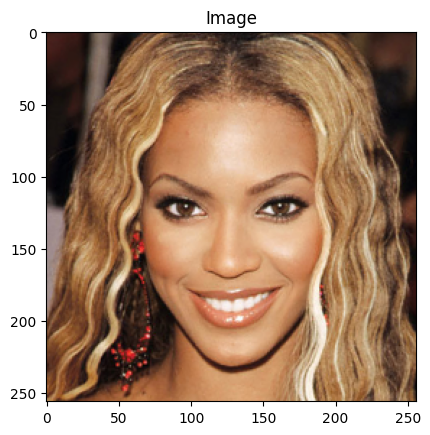

In [9]:
img = Image.open('test/beyonce.jpg')
img = img.convert('RGB')  # if image is RGBA or Grayscale etc
img = np.array(img)
plt.imshow(img)
plt.title('Image')

Text(0.5, 1.0, 'Reconstructed')

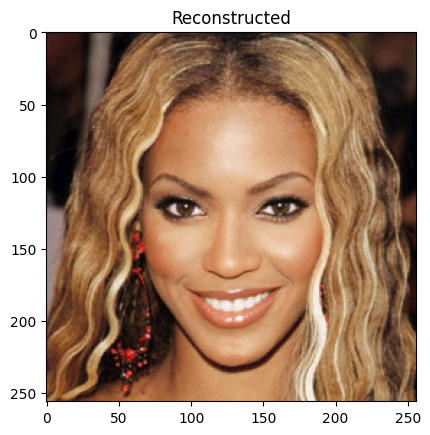

In [10]:
Z = encode(img)
im_dec = decode(Z)[0]
plt.imshow(im_dec)
plt.title('Reconstructed')

In [11]:
np.sqrt(np.sum((im_dec - img)**2))/np.sum(img) #Only minimal differences between original and reconstructed images

8.396819296300596e-05

## Moving in the latent space

### Mixing Morphing 

Here, we mix two faces by going on a straight line in the Z-Space from one face to the next 

In [12]:
def encode_image(filename):
  img = Image.open(filename)
  img = img.convert('RGB')  # if image is RGBA or Grayscale etc
  img = np.array(img)
  return encode(img)

Z1 = encode_image('test/beyonce.jpg')
Z2 = encode_image('test/leo.png')

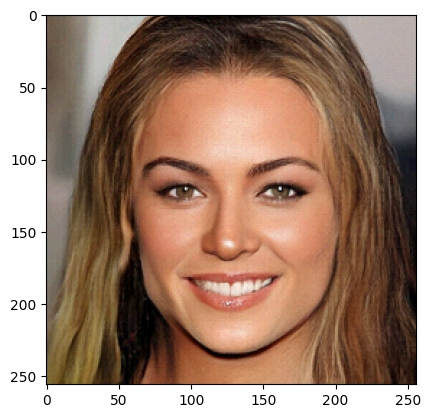

In [13]:
Z_mix = 0.5*(Z1+Z2)
img = decode(Z_mix)[0]
plt.imshow(img)

#### Task make an image with is 25% Beyonce 75% Leonardo

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  
Create an image with is 25% Beyonce and 75% Leonardo 


We can now morph between the two persons and make an smooth transition.

0.0
0.25
0.5
0.75
1.0


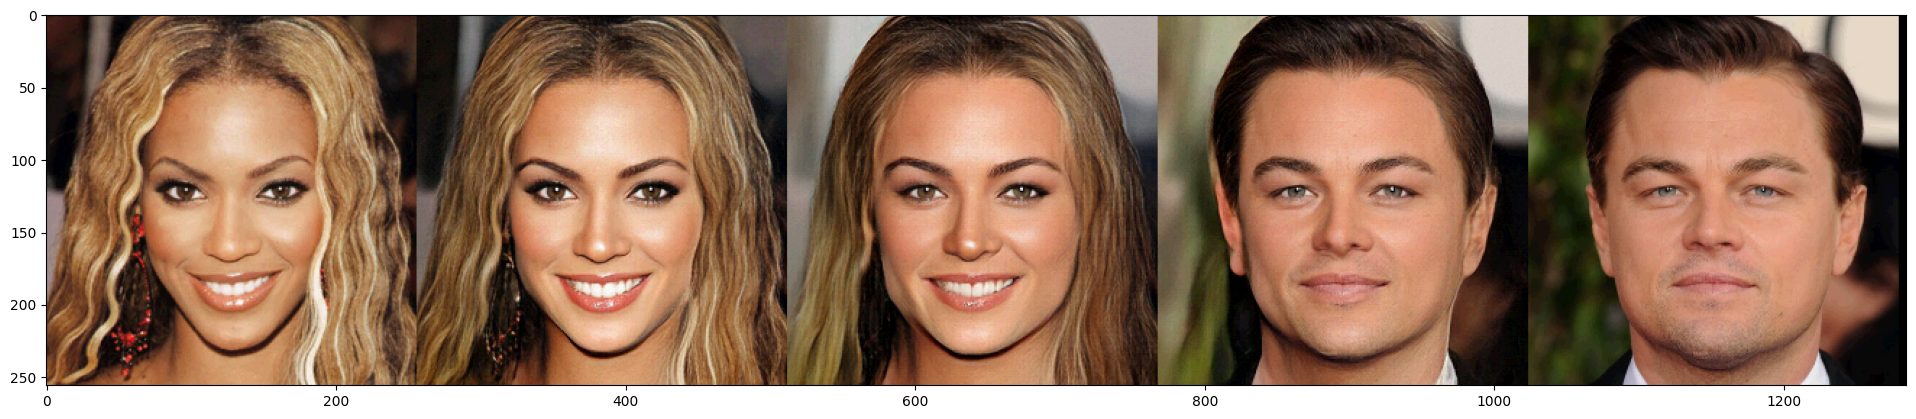

In [14]:
can = np.zeros((1*256,5*257,3),dtype='uint8')
for j in range(5):
    s = 0
    sx = j*256
    m = (j)/4
    print(m)
    Z_mix = (Z2*m+Z1*(1.-m))
    img = decode(Z_mix)[0]
    can[s:(s+256) , sx:(sx+256),0:3] = img

plt.figure(figsize=(24,6))
plt.imshow(can)
plt.imsave('beyone_leo.png', can)